In [1]:
import os
import sys
import multiprocessing as mp
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import scipy.stats as stats
import tqdm

sys.path.append('..')
from util.statdist import kl_divergence, bhattacharyya, wasserstein, log_likelihood
from util.plot import Background

%matplotlib inline

In [2]:
noises = [0, 1]
models = ["onestat", "twostat", "propwaves"]

## Load data

In [3]:
dfr = pd.read_pickle("../run/Taa/df-grouped-rec.pkl")
dfm = pd.read_pickle("../run/Taa/df-grouped-sim.pkl")

dfr = dfr[dfr.detconf == 0]
dfm = dfm[dfm.detconf == 0]

## Calculate results

In [10]:
np.random.seed(42)

nbins = 4
variables = ['tdur',         'tfr_slope',       'tfr_r2',   'pca_ve1',  'pca_ve2ac']
bins =      [(0, 20, nbins), (0.0, 0.6, nbins), (0.0, 1.0, nbins), (0.4, 1.0, nbins), (0.8, 1.0, nbins)]
nbootstrap  = 1000
nbootstrapw = 100

mus = np.array([dfr[var].mean() for var in variables])
stds = np.array([dfr[var].std() for var in variables])
bins = [((b[0] - mu)/std, (b[1] - mu)/std, b[2]) for b, mu, std in zip(bins, mus, stds)]


fms = {}
for model in models:
    for noise in noises:
        dff = dfm[(dfm.model == model) & (dfm.noise == noise)] 
        fms[model, noise] = (dff[variables].values - mus)/stds


nsamples = len(dfr)
fr = (dfr[variables].values - mus)/stds        

def calc_distances(inds, method):
    frres = fr[inds, :]    
    dists = np.zeros((len(models), len(noises)))
    
    for i, model in enumerate(models):
        for j, noise in enumerate(noises):
            fm = fms[model, noise]
            if method == 'll10':   dists[i,j] = log_likelihood(frres, fm, k=10)
            elif method == 'll50': dists[i,j] = log_likelihood(frres, fm, k=50)
            elif method == 'bhat': dists[i,j] = bhattacharyya(frres, fm, bins)
            elif method == 'wass': dists[i,j] = wasserstein(frres, fm, bins)
            
    return dists


inds = np.random.choice(nsamples, size=(nbootstrap, nsamples), replace=True)
dists = np.full((4, len(models), len(noises), nbootstrap), np.nan)

with mp.Pool(4) as pool:    
    for i, method in enumerate(['ll10', 'll50', 'bhat', 'wass']):
        fun = functools.partial(calc_distances, method=method)
        nbs = nbootstrap if method != 'wass' else nbootstrapw
        ds = list(tqdm.tqdm(pool.imap(fun, inds[:nbs]), total=nbs, position=0, leave=True))                    
        dists[i, :, :, :nbs] = np.moveaxis(ds, [0,1,2], [2,0,1])

np.save("res/distances.npy", dists)

100%|██████████| 1000/1000 [00:12<00:00, 77.33it/s]


In [12]:
dists = np.load("res/distances.npy")

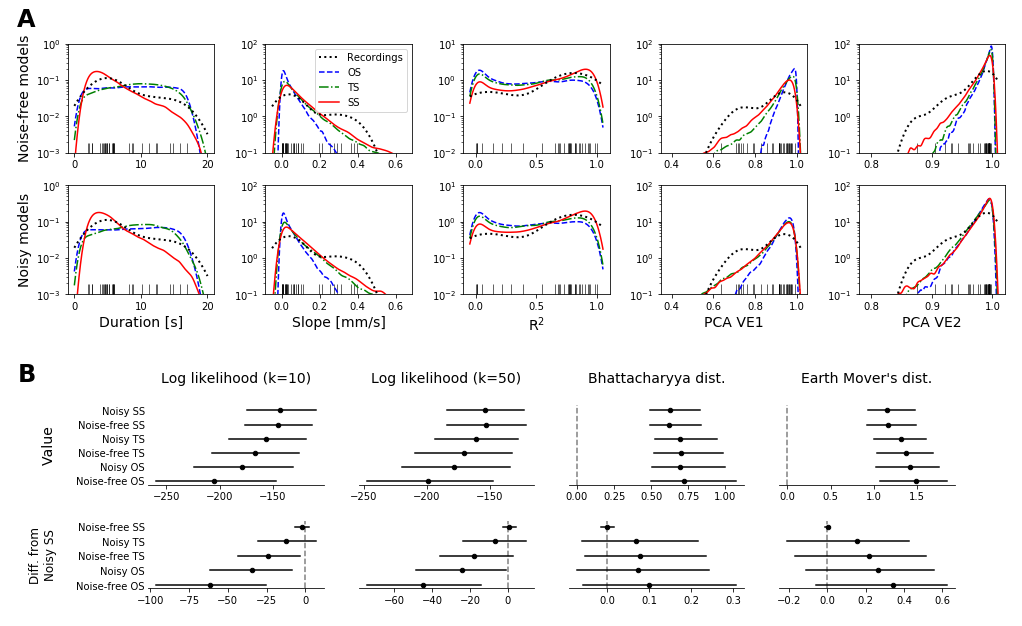

In [13]:
model_names = ["OS", "TS", "SS"]
noise_names = ["Noise-free", "Noisy"]

def remove_borders(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'y', length=0)
  
def plot_one_ci(ax, x, yticks, iref=None, jref=None, xref=None,):
    nmodels, nnoises, _ = x.shape
    ci = np.nanpercentile(x, [2.5, 50.0, 97.5], axis=-1)
    ci = np.moveaxis(ci, [0, 1, 2], [2, 0, 1])
    
    plt.sca(ax)

    labels = []
    ypos = 0
    for i in range(nmodels):
        for j in range(nnoises):
            if i != iref or j != jref:                
                plt.plot(ci[i, j, [0, 2]], [ypos, ypos], 'k-')
                plt.scatter(ci[i, j, 1], ypos, s=20, color='k')
                labels.append(noise_names[j] + " " + model_names[i])
                ypos += 1 
    if yticks:
        plt.yticks(np.r_[:len(labels)], labels)
    else:
        plt.yticks([])
    
    if xref is not None:
        plt.axvline(xref, ls='--', color='0.5', zorder=-1)
    remove_borders(ax)

    
def plot_ci(axes, x, name, ref=None, yticks=True, ylabel=False):
    nmodels, nnoises, nsamples = x.shape
        
    # Values
    ax = plt.subplot(axes[0])
    plt.title(name, fontsize=14)
    plot_one_ci(ax, x, yticks, xref=ref)
    if ylabel:
        plt.ylabel("Value\n", fontsize=14)

    # Differences from noisy SS model
    ax = plt.subplot(axes[1])
    dx = x - x[2, 1, :]
    plot_one_ci(ax, dx, yticks, iref=2, jref=1, xref=0.)    
    if ylabel:
        plt.ylabel("Diff. from\nNoisy SS\n", fontsize=12)
    

def plot_densities(gs, dfr, dfm):
    models = ['onestat', 'twostat', 'propwaves']
    model_names = ['OS', 'TS', 'SS']
    colors = ['b', 'g', 'r']
    styles = ['--', '-.', '-']

    variables = ['tdur',         'tfr_slope',     'tfr_r2',      'pca_ve1',   'pca_ve2ac']
    labels =    ["Duration [s]",  "Slope [mm/s]",       "R$^2$",       "PCA VE1",   "PCA VE2"]
    limits =    [(0, 20),     (-0.05, 0.65), (-0.05, 1.05), (0.38, 1.02), (0.79, 1.01)]
    ylims =     [(1e-3, 1e0), (1e-1, 1e2),   (1e-2, 1e1),   (1e-1, 1e2), (1e-1, 1e2)]

    bw = 'scott'
    
    for i, noise in enumerate(noises):
        for j, var in enumerate(variables):

            ax = plt.subplot(gs[i, j])
            lim = limits[j]

            dfr[var].plot(kind='density', color='k', ls=':', ind=np.linspace(lim[0], lim[1], 1000), lw=2, zorder=5,
                          bw_method=bw, label="Recordings")
            for k, model in enumerate(models):
                dff = dfm[(dfm.model == model) & (dfm.noise == noise)]
                dff[var].plot(kind='density', ind=np.linspace(lim[0], lim[1], 1000), bw_method=bw, label=model_names[k],
                             color=colors[k], ls=styles[k])

            plt.xlabel(labels[j] if i == 1 else "", fontsize=14)
            plt.yscale('log')
            plt.ylim(ylims[j])
            plt.ylabel("")

            plt.scatter(dfr[var], ylims[j][0]*np.ones(len(dfr)), marker=2, color='k', s=100, linewidth=0.6)

            if i == 0 and j == 1:
                plt.legend(loc='upper right')

            if j == 0:
                plt.ylabel("Noise-free models" if i == 0 else "Noisy models", fontsize=14)    


fig = plt.figure(figsize=(14, 8.5))

# Panel A: Densities -----------------------------------------------------------------------------------------
gsA = GridSpec(2, 5, hspace=0.3, wspace=0.35, left=0.06, right=0.99, top=0.94, bottom=0.53)
plot_densities(gsA, dfr, dfm)

# Panel B: Distances -----------------------------------------------------------------------------------------
gsB = GridSpec(2, 4, hspace=0.5, wspace=0.2, left=0.14, right=0.94, top=0.35, bottom=0.05, height_ratios=[6,5])
plot_ci([gsB[0,0], gsB[1,0]], dists[0], name="Log likelihood (k=10)\n", ylabel=True)
plot_ci([gsB[0,1], gsB[1,1]], dists[1], name="Log likelihood (k=50)\n", yticks=False)
plot_ci([gsB[0,2], gsB[1,2]], dists[2], name="Bhattacharyya dist.\n", ref=0.0, yticks=False)
plot_ci([gsB[0,3], gsB[1,3]], dists[3], name="Earth Mover's dist.\n", ref=0.0, yticks=False)


bg = Background(visible=False)
bg.labels([0.01, 0.01], [0.96, 0.38], fontsize=24)
plt.savefig("figs/model-comparison.pdf")